In [9]:
%matplotlib inline
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
import sklearn.datasets
import theano
import theano.tensor as T
import lasagne
import math


# Variational Autoencoders

In this exercise we'll implement an variational autoencoder. Very briefly an autoencoder encodes some input into a new representaiton and usually more compact representation which can be used to reconstruct the input data again. An variational autoencoder makes the furhter assumption that the compact representation is follows probabilistic distribution (usually a gaussian) which makes it possible to sample new data from a trained variational autoencoder. The "variational" part of the name comes from the fact that these models are training using variational inference.

The mathematical details of the training can be a bit challenging however we believe that probabilistic deep learning will be an important part of future deep learning developments why we find it important to introduce the concepts.

As bacground material we recommend reading [Tutorial on Variational Autoencoder](http://arxiv.org/abs/1606.05908). For the implementation of the model you must read the article "Auto-Encoding Variational Bayes", Kingma & Welling, ICLR 2014: http://arxiv.org/pdf/1312.6114v10.pdf and "Stochastic Backpropagation and Approximate Inference in Deep Generative Models", Rezende et al, ICML 2014:
http://arxiv.org/pdf/1401.4082v3.pdf



## VAE crash course

VAEs consist of two parts:

 * Encoder (also known as recognition, inference or Q-model): Maps the input data into a probabilistic latent space by calculating the mean and variance parameters of a gaussian distribution as a function of the input data x:  $q(z|x) = \mathcal{N}(z|\mu_\theta(x), \sigma_\phi(x)I)$
 * Decoder (also known as generative or P-model): Reconstructs the input image using a sample from the latent space defined by the encoder model: $p(x|z)$
<img src="VAE.png" alt="Drawing" style="width: 300px;"/>


In more mathematical details we have (this can be a bit challenging)

$p(x) = \int_z p(x|z)p(z)dz$

$p(x) = \int_z p(x|z)p(z)\frac{q(z|x)}{q(z|x)}dz$


$p(x) = \int_z q(z|x) \frac{p(x|z)p(z)}{q(z|x)}dz$


$\log p(x) = \log \int_z q(z|x) \frac{p(x|z)p(z)}{q(z|x)}dz$

$\log p(x) \geq  \int_z q(z|x)\log \frac{p(x|z)p(z)}{q(z|x)}dz$

This is know as the variational lower bound. We contiue with a bit of rewriting

$\log p(x) \geq E_{q(z|x)} \left[\log \frac{p(x|z)p(z)}{q(z|x)}\right]$

$\log p(x) \geq E_{q(z|x)} \left[\log p(x|z)\right] - KL(q(z|x) | p(z))$

Here the first term on the right hand side are the data reconstruction and the second term the Kulback-Liebler divergenve between the approximate and true posterior distributions which acts as a probabilistic regularizer.


In [180]:
#To speed up training we'll only work on a subset of the data
#We discretize the data to 0 and 1 in order to use it with a bernoulli observation model p(x|z) = Ber(mu(z))

def bernoullisample(x):
    return np.random.binomial(1,x,size=x.shape).astype(theano.config.floatX)


data = np.load('mnist.npz')
num_classes = 10
x_train = bernoullisample(data['X_train'][:50000]).astype('float32')
targets_train = data['y_train'][:50000].astype('int32')

x_valid = bernoullisample(data['X_valid'][:500]).astype('float32')
targets_valid = data['y_valid'][:500].astype('int32')

x_test = bernoullisample(data['X_test'][:500]).astype('float32')
targets_test = data['y_test'][:500].astype('int32')

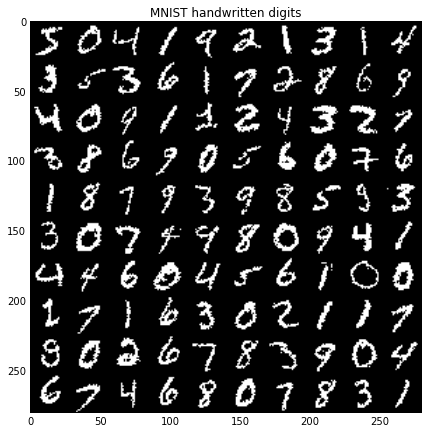

In [97]:
#plot a few MNIST examples

def plot_samples(x,title=''):
    idx = 0
    canvas = np.zeros((28*10, 10*28))
    for i in range(10):
        for j in range(10):
            canvas[i*28:(i+1)*28, j*28:(j+1)*28] = x[idx].reshape((28, 28))
            idx += 1
    plt.figure(figsize=(7, 7))
    plt.imshow(canvas, cmap='gray')
    plt.title(title)
    plt.show()

plot_samples(x_train[:100],title='MNIST handwritten digits')

In [98]:
#defined a couple of helper functions
c = - 0.5 * math.log(2*math.pi)
def log_bernoulli(x, p, eps=0.0):
    p = T.clip(p, eps, 1.0 - eps)
    return -T.nnet.binary_crossentropy(p, x)

def kl_normal2_stdnormal(mean, log_var):
    return -0.5*(1 + log_var - mean**2 - T.exp(log_var))


Construct the lasagne layer.

In [99]:
from lasagne.layers import InputLayer,DenseLayer,get_output, get_all_params
from lasagne.nonlinearities import elu, identity, sigmoid
from samplelayer import SimpleSampleLayer

num_features = x_train.shape[-1]
num_latent_z = 64

#MODEL SPECIFICATION

#ENCODER
l_in_x = InputLayer(shape=(None, num_features))
l_enc = DenseLayer(l_in_x, num_units=256, nonlinearity=elu)
l_enc = DenseLayer(l_enc, num_units=256, nonlinearity=elu) 
l_muq = DenseLayer(l_enc, num_units=num_latent_z, nonlinearity=identity)     #mu(x)
l_logvarq = DenseLayer(l_enc, num_units=num_latent_z, nonlinearity=lambda x: T.clip(x,-10,10)) #logvar(x), 

l_z = SimpleSampleLayer(mean=l_muq, log_var=l_logvarq) #sample a latent representation z \sim q(z|x) = N(mu(x),logvar(x))

#we split the in two parts to allow sampling from the decoder model separately

#DECODER
l_in_z = InputLayer(shape=(None, num_latent_z))
l_dec = DenseLayer(l_in_z, num_units=256, nonlinearity=elu) 
l_dec = DenseLayer(l_dec, num_units=256, nonlinearity=elu) 
l_mux = DenseLayer(l_dec, num_units=num_features, nonlinearity=sigmoid)  #reconstruction of input using a sigmoid output since mux \in [0,1] 

In [105]:

sym_x = T.matrix('x')
sym_z = T.matrix('z')

z_train, muq_train, logvarq_train = get_output([l_z,l_muq,l_logvarq],{l_in_x:sym_x},deterministic=False)
mux_train = get_output(l_mux,{l_in_z:z_train},deterministic=False)

z_eval, muq_eval, logvarq_eval = get_output([l_z,l_muq,l_logvarq],{l_in_x:sym_x},deterministic=True)
mux_eval = get_output(l_mux,{l_in_z:z_eval},deterministic=True)

mux_sample = get_output(l_mux,{l_in_z:sym_z},deterministic=True)



#defined the cost function

def LogLikelihood(mux,x,muq,logvarq):
    log_px_given_z = log_bernoulli(x, mux, eps=1e-6).sum(axis=1).mean() #note that we sum the latent dimension and mean over the samples
    KL_qp = kl_normal2_stdnormal(muq, logvarq).sum(axis=1).mean()
    LL = log_px_given_z - KL_qp
    return LL, log_px_given_z, KL_qp


LL_train, logpx_train, KL_train = LogLikelihood(mux_train, sym_x, muq_train, logvarq_train)
LL_eval, logpx_eval, KL_eval = LogLikelihood(mux_eval, sym_x, muq_eval, logvarq_eval)


all_params = get_all_params([l_z,l_mux],trainable=True)

# Let Theano do its magic and get all the gradients we need for training
all_grads = T.grad(-LL_train, all_params)


# Set the update function for parameters 
# you might wan't to experiment with more advanded update schemes like rmsprob, adadelta etc.
updates = lasagne.updates.adam(all_grads, all_params, learning_rate=1e-3)


f_train = theano.function(inputs=[sym_x],
                          outputs=[LL_train, logpx_train, KL_train],
                          updates=updates)

f_eval = theano.function(inputs=[sym_x],
                         outputs=[LL_train, logpx_train, KL_train])

f_sample= theano.function(inputs=[sym_z],
                         outputs=[mux_sample])

f_recon= theano.function(inputs=[sym_x],
                         outputs=[mux_eval])



In [101]:
#Test the forward pass
print  f_train(x_valid)

[array(-565.9327392578125, dtype=float32), array(-554.8701171875, dtype=float32), array(11.062651634216309, dtype=float32)]


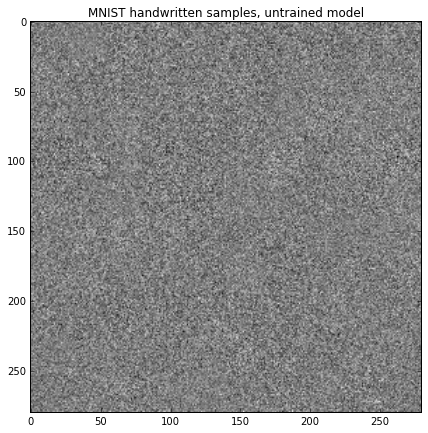

In [102]:
#plot some samples from the untrained model
z = np.random.normal(0,1,size=(100,num_latent_z)).astype('float32')
mux_sample = f_sample(z)[0]

plot_samples(mux_sample,title='MNIST handwritten samples, untrained model')

Train the model.

Epoch 0	Train: LL: -98.8	KL -72.1	logpx: 26.7	Valid: LL: -101.5	KL -75.0	logpx: 26.5
Epoch 1	Train: LL: -98.6	KL -72.0	logpx: 26.7	Valid: LL: -101.2	KL -74.5	logpx: 26.7
Epoch 2	Train: LL: -98.5	KL -71.8	logpx: 26.7	Valid: LL: -100.4	KL -74.4	logpx: 26.0
Epoch 3	Train: LL: -98.4	KL -71.7	logpx: 26.7	Valid: LL: -100.5	KL -74.5	logpx: 26.0
Epoch 4	Train: LL: -98.3	KL -71.6	logpx: 26.7	Valid: LL: -100.5	KL -74.3	logpx: 26.2
Epoch 5	Train: LL: -98.2	KL -71.6	logpx: 26.7	Valid: LL: -101.2	KL -74.8	logpx: 26.4
Epoch 6	Train: LL: -98.2	KL -71.5	logpx: 26.7	Valid: LL: -100.8	KL -74.4	logpx: 26.4
Epoch 7	Train: LL: -98.0	KL -71.3	logpx: 26.7	Valid: LL: -100.4	KL -74.2	logpx: 26.2
Epoch 8	Train: LL: -98.0	KL -71.3	logpx: 26.7	Valid: LL: -100.4	KL -73.8	logpx: 26.6
Epoch 9	Train: LL: -97.9	KL -71.2	logpx: 26.7	Valid: LL: -101.3	KL -74.9	logpx: 26.4
Epoch 10	Train: LL: -97.9	KL -71.1	logpx: 26.8	Valid: LL: -100.5	KL -74.4	logpx: 26.1
Epoch 11	Train: LL: -97.8	KL -71.1	logpx: 26.7	Valid: LL: -100.8

(<matplotlib.text.Text at 0x116678090>, <matplotlib.text.Text at 0x120e88110>)

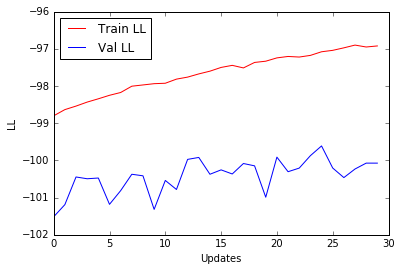

In [108]:
num_epochs = 30
batch_size = 64
num_batch_train = x_train.shape[0] // batch_size
 
LL_train, KL_train, logpx_train = [],[],[]
LL_valid, KL_valid, logpx_valid = [],[],[]

for e in range(num_epochs):
    _LL_train, _KL_train, _logpx_train = [],[],[]
    for i in range(num_batch_train):
        out = f_train(x_train[batch_size*i:(i+1)*batch_size])
        #out = [LL, logpx,KL_qp]
        _LL_train += [out[0]]
        _logpx_train += [out[1]]
        _KL_train += [out[2]]
        
    LL_train += [np.mean(_LL_train)] 
    KL_train += [np.mean(_KL_train)] 
    logpx_train += [np.mean(_logpx_train)] 
    
    out = f_eval(x_valid)
    LL_valid += [out[0]]
    logpx_valid += [out[1]]
    KL_valid += [out[2]]

    print "Epoch %i\t"%(e) + \
    "Train: LL: %0.1f\tKL %0.1f\tlogpx: %0.1f\t"%(LL_train[-1],KL_train[-1],logpx_train[-1]) + \
    "Valid: LL: %0.1f\tKL %0.1f\tlogpx: %0.1f"%(LL_valid[-1],KL_valid[-1],logpx_valid[-1])


epoch = np.arange(len(LL_train))
plt.figure()
plt.plot(epoch,LL_train,'r',epoch,LL_valid,'b')
plt.legend(['Train LL','Val LL'],loc='best')
plt.xlabel('Updates'), plt.ylabel('LL')



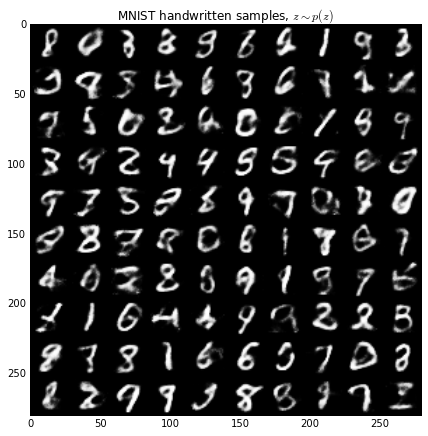

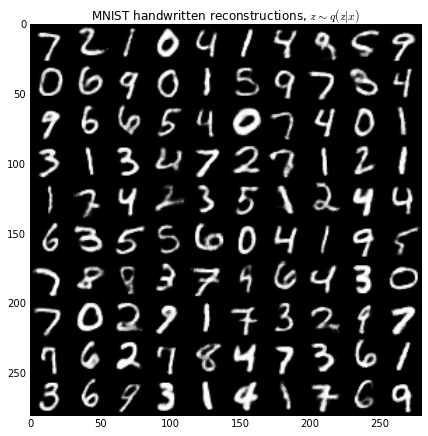

In [107]:
#plot some samples from the trained model
mux_sample = f_sample(z)[0]
plot_samples(mux_sample,title='MNIST handwritten samples, $z\sim p(z)$')

#plot some samples from the trained model
mux_recon = f_recon(x_test[:100])[0]
plot_samples(mux_recon,title='MNIST handwritten reconstructions, $z\sim q(z|x)$')


# OPTIONAL: Denoising VAE

Autoencoders can be used for denoising images. Here we demonstrate how a VAE can be used for removing salt and pepper noise from the input images.

in math we have

$\log p(x_{clean}) = E_{z\sim q(z|x_{noisy})} \left[\log p(x_{clean}|z) \right] - KL(q(z|x_{noisy}|p(z))$

note that the the latent representation $z$ used for reconstructing $x_{clean}$ is now conditioned on $x_{noisy}$


In [ ]:
def saltandpepper(X, p=0.3):
    # salt and pepper noise
    a = np.random.binomial(size=X.shape, n=1,\
            p=1-p)
    b = np.random.binomial(size=X.shape, n=1,\
            p=p)

    c = (a==0) * b
    return (X * a + c).astype('float32')

In [193]:
data = np.load('mnist.npz')
num_classes = 10
noise_level = 0.6
data = np.load('mnist.npz')
num_classes = 10
x_train = bernoullisample(data['X_train'][:50000]).astype('float32')
x_valid = bernoullisample(data['X_valid'][:500]).astype('float32')
x_test = bernoullisample(data['X_test'][:500]).astype('float32')

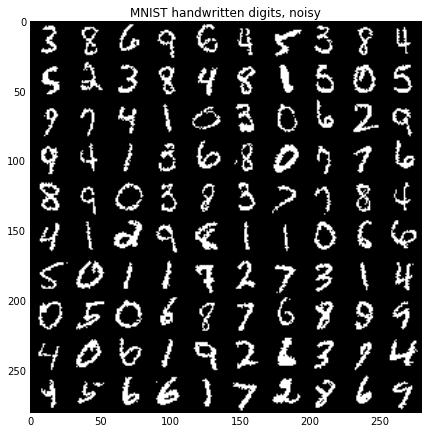

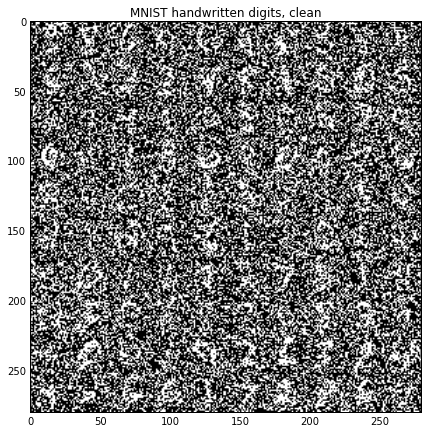

In [194]:
plot_samples(x_valid,title='MNIST handwritten digits, noisy')
plot_samples(saltandpepper(np.copy(x_valid),p=noise_level),title='MNIST handwritten digits, clean')

In [195]:
from lasagne.layers import InputLayer,DenseLayer,get_output, get_all_params
from lasagne.nonlinearities import elu, identity, sigmoid
from samplelayer import SimpleSampleLayer

num_features = x_train.shape[-1]
num_latent_z = 64

#MODEL SPECIFICATION

#ENCODER
l_in_x = InputLayer(shape=(None, num_features))
l_enc = DenseLayer(l_in_x, num_units=256, nonlinearity=elu)
l_enc = DenseLayer(l_enc, num_units=256, nonlinearity=elu) 
l_muq = DenseLayer(l_enc, num_units=num_latent_z, nonlinearity=identity)     #mu(x)
l_logvarq = DenseLayer(l_enc, num_units=num_latent_z, nonlinearity=lambda x: T.clip(x,-10,10)) #logvar(x), 

l_z = SimpleSampleLayer(mean=l_muq, log_var=l_logvarq) #sample a latent representation z \sim q(z|x) = N(mu(x),logvar(x))

#we split the in two parts to allow sampling from the decoder model separately

#DECODER
l_in_z = InputLayer(shape=(None, num_latent_z))
l_dec = DenseLayer(l_in_z, num_units=256, nonlinearity=elu) 
l_dec = DenseLayer(l_dec, num_units=256, nonlinearity=elu) 
l_mux = DenseLayer(l_dec, num_units=num_features, nonlinearity=sigmoid)  #reconstruction of input using a sigmoid output since mux \in [0,1] 

In [196]:

sym_x = T.matrix('x')
sym_xt = T.matrix('xt')
sym_z = T.matrix('z')

z_train, muq_train, logvarq_train = get_output([l_z,l_muq,l_logvarq],{l_in_x:sym_x},deterministic=False)
mux_train = get_output(l_mux,{l_in_z:z_train},deterministic=False)

z_eval, muq_eval, logvarq_eval = get_output([l_z,l_muq,l_logvarq],{l_in_x:sym_x},deterministic=True)
mux_eval = get_output(l_mux,{l_in_z:z_eval},deterministic=True)

mux_sample = get_output(l_mux,{l_in_z:sym_z},deterministic=True)



#defined the cost function

def LogLikelihood(mux,x,muq,logvarq):
    log_px_given_z = log_bernoulli(x, mux, eps=1e-6).sum(axis=1).mean() #note that we sum the latent dimension and mean over the samples
    KL_qp = kl_normal2_stdnormal(muq, logvarq).sum(axis=1).mean()
    LL = log_px_given_z - KL_qp
    return LL, log_px_given_z, KL_qp


LL_train, logpx_train, KL_train = LogLikelihood(mux_train, sym_xt, muq_train, logvarq_train)
LL_eval, logpx_eval, KL_eval = LogLikelihood(mux_eval, sym_xt, muq_eval, logvarq_eval)


all_params = get_all_params([l_z,l_mux],trainable=True)

# Let Theano do its magic and get all the gradients we need for training
all_grads = T.grad(-LL_train, all_params)


# Set the update function for parameters 
# you might wan't to experiment with more advanded update schemes like rmsprob, adadelta etc.
updates = lasagne.updates.adam(all_grads, all_params, learning_rate=1e-3)


f_train = theano.function(inputs=[sym_x,sym_xt],
                          outputs=[LL_train, logpx_train, KL_train],
                          updates=updates)

f_eval = theano.function(inputs=[sym_x,sym_xt],
                         outputs=[LL_train, logpx_train, KL_train])

f_sample= theano.function(inputs=[sym_z],
                         outputs=[mux_sample])

f_recon= theano.function(inputs=[sym_x],
                         outputs=[mux_eval])

Epoch 0	Train: LL: -203.7	KL 6.5	logpx: -197.1	Valid: LL: -181.9	KL 7.2	logpx: -174.7
Epoch 1	Train: LL: -177.2	KL 8.7	logpx: -168.6	Valid: LL: -171.8	KL 9.6	logpx: -162.2
Epoch 2	Train: LL: -168.5	KL 9.8	logpx: -158.7	Valid: LL: -168.1	KL 9.6	logpx: -158.5
Epoch 3	Train: LL: -164.3	KL 10.2	logpx: -154.2	Valid: LL: -163.1	KL 10.3	logpx: -152.8
Epoch 4	Train: LL: -161.9	KL 10.5	logpx: -151.3	Valid: LL: -161.3	KL 10.2	logpx: -151.1
Epoch 5	Train: LL: -159.7	KL 10.9	logpx: -148.8	Valid: LL: -158.8	KL 10.1	logpx: -148.7
Epoch 6	Train: LL: -158.3	KL 11.2	logpx: -147.2	Valid: LL: -159.1	KL 10.6	logpx: -148.5
Epoch 7	Train: LL: -157.4	KL 11.3	logpx: -146.1	Valid: LL: -157.7	KL 10.9	logpx: -146.8
Epoch 8	Train: LL: -156.2	KL 11.5	logpx: -144.7	Valid: LL: -153.6	KL 11.3	logpx: -142.3
Epoch 9	Train: LL: -155.3	KL 11.7	logpx: -143.6	Valid: LL: -156.1	KL 11.0	logpx: -145.1
Epoch 10	Train: LL: -154.6	KL 11.8	logpx: -142.8	Valid: LL: -155.2	KL 11.7	logpx: -143.6
Epoch 11	Train: LL: -154.1	KL 11.9	lo

(<matplotlib.text.Text at 0x12483ad10>, <matplotlib.text.Text at 0x12483ae10>)

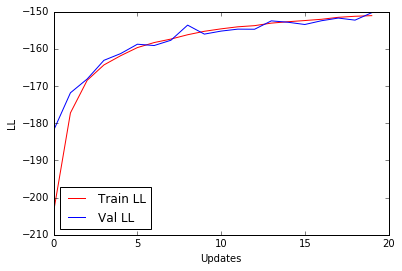

In [197]:
num_epochs = 20
batch_size = 64
num_batch_train = x_train.shape[0] // batch_size
 
LL_train, KL_train, logpx_train = [],[],[]
LL_valid, KL_valid, logpx_valid = [],[],[]

for e in range(num_epochs):
    _LL_train, _KL_train, _logpx_train = [],[],[]
    for i in range(num_batch_train):
        out = f_train(saltandpepper(np.copy(x_train[batch_size*i:(i+1)*batch_size]),p=noise_level), 
                      x_train[batch_size*i:(i+1)*batch_size])
        #out = [LL, logpx,KL_qp]
        _LL_train += [out[0]]
        _logpx_train += [out[1]]
        _KL_train += [out[2]]
        
    LL_train += [np.mean(_LL_train)] 
    KL_train += [np.mean(_KL_train)] 
    logpx_train += [np.mean(_logpx_train)] 
    
    out = f_eval(saltandpepper(np.copy(x_valid),p=noise_level), 
                 x_valid)
    LL_valid += [out[0]]
    logpx_valid += [out[1]]
    KL_valid += [out[2]]

    print "Epoch %i\t"%(e) + \
    "Train: LL: %0.1f\tKL %0.1f\tlogpx: %0.1f\t"%(LL_train[-1],KL_train[-1],logpx_train[-1]) + \
    "Valid: LL: %0.1f\tKL %0.1f\tlogpx: %0.1f"%(LL_valid[-1],KL_valid[-1],logpx_valid[-1])


epoch = np.arange(len(LL_train))
plt.figure()
plt.plot(epoch,LL_train,'r',epoch,LL_valid,'b')
plt.legend(['Train LL','Val LL'],loc='best')
plt.xlabel('Updates'), plt.ylabel('LL')


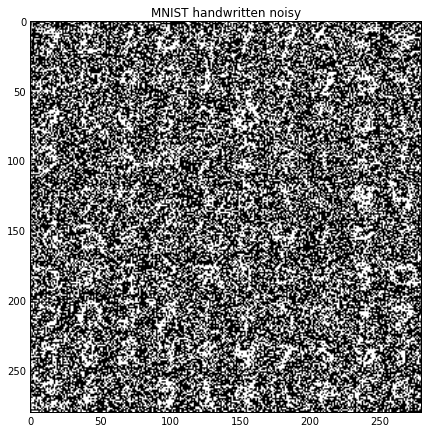

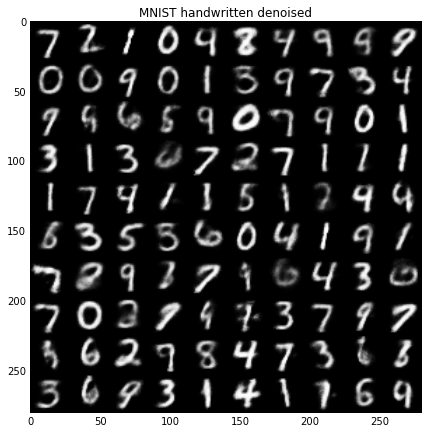

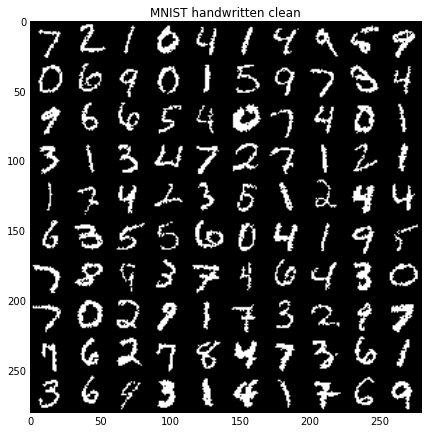

In [ ]:
x_noise = saltandpepper(np.copy(x_test[:100]),p=noise_level)
plot_samples(x_noise,title='MNIST handwritten noisy')

mux_recon = f_recon(x_test[:100])[0]
plot_samples(mux_recon,title='MNIST handwritten denoised')

plot_samples(x_test[:100],title='MNIST handwritten clean')

